# Group Number:
# Student 1:
# Student 2:
# Student 3:

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [51]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

In [3]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/TUe/DeepLearning"

In [4]:
# # UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content)

Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [6]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [7]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


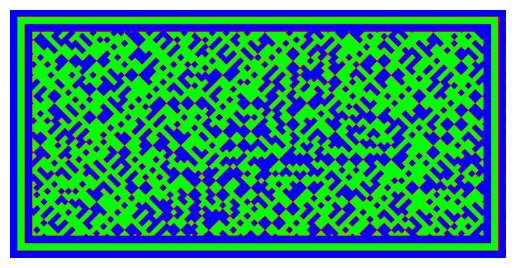

In [126]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
X_train[:10].shape

torch.Size([10, 1, 96, 60])

In [11]:
x = sc.Slice(rotation=4, reflection=True)(X_train[:10])

In [12]:
x.shape

torch.Size([10, 8, 1, 96, 60])

In [21]:
sc.SymmetryConv2d(in_filters=1, out_filters=4, kernel_size=4, stride=4, rotation=4)(x).shape

torch.Size([10, 8, 4, 24, 15])

In [127]:
class SymModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rot_slc = sc.Slice(rotation=4, reflection=False)
        self.convs = nn.Sequential(sc.SymmetryConv2d(in_filters=1, out_filters=16, kernel_size=4, stride=4, rotation=4, reflection=False),
                                   nn.ReLU(),
                                    sc.SymmetryConv2d(in_filters=16, out_filters=32, kernel_size=3, stride=3, rotation=4, reflection=False),
                                   nn.ReLU()
                                    )
        self.pool = sc.SymmetryPool()
        self.lin1 = nn.Linear(1280, 256)
        self.lin2 = nn.Linear(256, 3)
        
    def forward(self, x):
        x = self.rot_slc(x)
        x = self.convs(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.lin1(torch.flatten(x, start_dim=1))
        x = self.lin2(x)

        return x

In [128]:
model = SymModel().to(device)

In [129]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

criterion = nn.CrossEntropyLoss()

In [130]:
EPOCHS = 30

for epoch in tqdm(range(EPOCHS)):
    
    model.train()
    
    train_losses = []

    train_acc, train_count = 0, 0

    for batch in train_dataloader:
        x, y = batch
        input, labels = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(input)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        train_acc += (labels.argmax(dim=-1) == output.argmax(dim=-1)).sum().item()

        train_count += labels.size(0)

    model.eval()

    valid_acc, valid_count = 0, 0


    for batch in valid_dataloader:

        x, y = batch
        input, labels = x.to(device), y.to(device)

        with torch.no_grad():
            output = model(input)
            
            valid_acc += (labels.argmax(dim=-1) == output.argmax(dim=-1)).sum().item()

            valid_count += labels.size(0)



    print(f'Train acc: {train_acc / train_count:.4f}',end=' ')
    print(f'Val acc: {valid_acc / valid_count:.4f}',end='\n')

  3%|▎         | 1/30 [00:01<00:41,  1.44s/it]

Train acc: 0.3324 Val acc: 0.3075


  7%|▋         | 2/30 [00:02<00:39,  1.42s/it]

Train acc: 0.3747 Val acc: 0.3285


 10%|█         | 3/30 [00:04<00:37,  1.41s/it]

Train acc: 0.4223 Val acc: 0.3300


 13%|█▎        | 4/30 [00:05<00:36,  1.39s/it]

Train acc: 0.4388 Val acc: 0.3450


 17%|█▋        | 5/30 [00:07<00:36,  1.44s/it]

Train acc: 0.4485 Val acc: 0.3380


 20%|██        | 6/30 [00:08<00:37,  1.57s/it]

Train acc: 0.4527 Val acc: 0.3360


 23%|██▎       | 7/30 [00:10<00:36,  1.57s/it]

Train acc: 0.4599 Val acc: 0.3385


 27%|██▋       | 8/30 [00:11<00:33,  1.51s/it]

Train acc: 0.4713 Val acc: 0.3360


 30%|███       | 9/30 [00:13<00:30,  1.47s/it]

Train acc: 0.4775 Val acc: 0.3355


 33%|███▎      | 10/30 [00:14<00:28,  1.45s/it]

Train acc: 0.4831 Val acc: 0.3385


 37%|███▋      | 11/30 [00:16<00:27,  1.43s/it]

Train acc: 0.4865 Val acc: 0.3350


 40%|████      | 12/30 [00:17<00:25,  1.42s/it]

Train acc: 0.4944 Val acc: 0.3290


 43%|████▎     | 13/30 [00:18<00:23,  1.41s/it]

Train acc: 0.5003 Val acc: 0.3220


 47%|████▋     | 14/30 [00:20<00:22,  1.44s/it]

Train acc: 0.5113 Val acc: 0.3275


 50%|█████     | 15/30 [00:22<00:23,  1.56s/it]

Train acc: 0.5196 Val acc: 0.3395


 53%|█████▎    | 16/30 [00:23<00:22,  1.58s/it]

Train acc: 0.5289 Val acc: 0.3200


 57%|█████▋    | 17/30 [00:25<00:19,  1.52s/it]

Train acc: 0.5340 Val acc: 0.3375


 60%|██████    | 18/30 [00:26<00:18,  1.52s/it]

Train acc: 0.5365 Val acc: 0.3250


 63%|██████▎   | 19/30 [00:28<00:16,  1.50s/it]

Train acc: 0.5472 Val acc: 0.3085


 67%|██████▋   | 20/30 [00:30<00:16,  1.64s/it]

Train acc: 0.5495 Val acc: 0.3270


 70%|███████   | 21/30 [00:31<00:14,  1.61s/it]

Train acc: 0.5593 Val acc: 0.3310


 73%|███████▎  | 22/30 [00:33<00:12,  1.54s/it]

Train acc: 0.5636 Val acc: 0.3250


 77%|███████▋  | 23/30 [00:34<00:11,  1.62s/it]

Train acc: 0.5712 Val acc: 0.3355


 80%|████████  | 24/30 [00:36<00:10,  1.67s/it]

Train acc: 0.5753 Val acc: 0.3400


 83%|████████▎ | 25/30 [00:38<00:07,  1.58s/it]

Train acc: 0.5837 Val acc: 0.3300


 87%|████████▋ | 26/30 [00:39<00:06,  1.54s/it]

Train acc: 0.5865 Val acc: 0.3220


 90%|█████████ | 27/30 [00:40<00:04,  1.50s/it]

Train acc: 0.5980 Val acc: 0.3170


 93%|█████████▎| 28/30 [00:42<00:03,  1.58s/it]

Train acc: 0.5995 Val acc: 0.3420


 97%|█████████▋| 29/30 [00:44<00:01,  1.62s/it]

Train acc: 0.6023 Val acc: 0.3290


100%|██████████| 30/30 [00:45<00:00,  1.53s/it]

Train acc: 0.6132 Val acc: 0.3455


## Task 1: Question 5d

# Task 2: Carpet Matching 

In [ ]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

In [ ]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().cuda()
        t = targets[i].float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [ ]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###